<h4>Load in the data and libraries<h4>

In [1]:
#Imports some of the libraries that we will be using
import pandas as pd
import numpy as np
import math
import warnings
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn import metrics
from sklearn import tree
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import time
warnings.filterwarnings('ignore')


In [2]:
from load_dataset import load
from classifier import NeuralNetwork, Logistic_Regression, SVM
from utils import *
from metrics import *  # include fairness and corresponding derivatives
from expl import explanation_candidate_generation, get_top_k_expl
from influence import *

['acs_income.csv', 'acs_influence_new.ipynb', 'adult.data', 'adult.test', 'adult_influence.ipynb', 'classifier.py', 'compas-scores-two-years.csv', 'compas_influence.ipynb', 'config.json', 'expl.py', 'functions.py', 'german.data', 'german_influence.ipynb', 'german_influence_copy.ipynb', 'influence.py', 'load_dataset.py', 'loss.py', 'metrics.py', 'random_influence.ipynb', 'sqf_influence.ipynb', 'sqf_test.csv', 'sqf_train.csv', 'utils.py', '__pycache__']


In [3]:
#Function to run the logistic regression model based on classifier.py
def lr_model(training_df, test_attr_df, classifier):
    changed_df_labels = training_df.pop('frisked')
    changed_df_attr = training_df.to_numpy()

    classifier.fit(changed_df_attr,changed_df_labels.values)
    y_predicted = classifier.predict_proba(test_attr_df)

    training_df['frisked'] = changed_df_labels

    return y_predicted


<h3>Leave One Out Training INF Calc<h3>

In [4]:
#list of solution times
sol_time = []

In [5]:
dataset = 'sqf'
clf_name = 'Logistic_Regression'
metric = 0
support = 0.05
support_small = 0.3

In [6]:
X_train, X_test, y_train, y_test = load(dataset)

In [7]:
duplicates = 1
make_duplicates = lambda x, d: pd.concat([x]*d, axis=0).reset_index(drop=True)
X_train = make_duplicates(X_train, duplicates)
X_test = make_duplicates(X_test, duplicates)
y_train = make_duplicates(y_train, duplicates)
y_test = make_duplicates(y_test, duplicates)

In [8]:
import copy
X_train_orig = copy.deepcopy(X_train)
X_test_orig = copy.deepcopy(X_test)

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [9]:
predictors = ['race', 'build', 'age', 'ht_feet', 'weight', 'perobs', 'cs_objcs',
       'cs_descr', 'cs_casng', 'cs_lkout', 'cs_drgtr', 'cs_vcrim', 'ac_proxm',
       'inout_I', 'inout_O', 'sex_F', 'sex_M']
target_var = ['frisked']

In [10]:
#Combine x_train and y_train
#I combine these so that when I flip the labels I have one DF that I work with
#Rather than 2 numpy.ndarrays
train_demo_df = pd.DataFrame(X_train, columns = predictors)
train_outcome_df = y_train.to_frame()
#train_outcome_df=train_outcome_df.rename(columns={'credit':'credit_risk'})
train_full_df = pd.concat([train_demo_df, train_outcome_df], axis=1)

In [11]:
clf = eval(clf_name)(input_size=X_train.shape[-1])

num_params = len(convert_grad_to_ndarray(list(clf.parameters())))
if isinstance(clf, Logistic_Regression):
    loss_func = logistic_loss_torch
elif isinstance(clf, SVM):
    loss_func = svm_loss_torch
elif isinstance(clf, NeuralNetwork):
    loss_func = nn_loss_torch
else:
    raise NotImplementedError

In [12]:
clf = eval(clf_name)(input_size=X_train.shape[-1])

clf.fit(X_train, y_train)

y_pred_test = clf.predict_proba(X_test)
y_pred_train = clf.predict_proba(X_train)

spd_0 = computeFairness(y_pred_test, X_test_orig, y_test, 0, dataset)
print("Initial statistical parity: ", spd_0)

tpr_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 1, dataset)
print("Initial TPR parity: ", tpr_parity_0)

predictive_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 2, dataset)
print("Initial predictive parity: ", predictive_parity_0)

accuracy_0 = computeAccuracy(y_test, y_pred_test)
print("Initial accuracy: ", accuracy_0)

Initial statistical parity:  -0.06874626497856756
Initial TPR parity:  -0.06270783144277586
Initial predictive parity:  -0.07477904554118925
Initial accuracy:  0.6829706361471952


<h5>Calculate the Influence of each of the datapoints<h5>

In [13]:
metric_val = [spd_0, tpr_parity_0, predictive_parity_0][metric]
del_F_del_theta = get_del_F_del_theta(clf, X_test_orig, X_test, y_test, dataset, metric)

In [14]:
hessian_all_points = get_hessian_all_points(clf, X_train, y_train, loss_func)

100%|██████████| 48605/48605 [04:41<00:00, 172.85it/s]


In [15]:
del_L_del_theta = get_del_L_del_theta(clf, X_train, y_train, loss_func)

In [16]:
hinv_v, hinv = get_hinv_v(hessian_all_points, np.transpose(del_L_del_theta))
#incorporate del_l_del_theta_i with the updated datapoint

In [17]:
#negative of inverse
negative_hinv_v = -1 * hinv_v

In [18]:
inf = np.matmul(np.transpose(negative_hinv_v), del_F_del_theta)
#For the new datapoint re-calculate the hinv_v

In [19]:
inf = (-1/(len(X_train))) *inf 

In [20]:
decimal_array = [format(num, '.10f') for num in inf]
decimal_array = [float(num) for num in decimal_array]

<h5>Leave One Out Training<h5>

In [21]:
copy_train = train_full_df.copy()
difference = []

for index in copy_train.index:
    df_dropped = copy_train.copy()
    df_dropped = copy_train.drop(index)
    #Run lr_model() to get predicted probabilities
    ypred = lr_model(df_dropped, X_test, clf)
    parity = computeFairness(ypred, X_test_orig, y_test, 0, dataset)
    
    parity = parity-spd_0

    difference.append(parity)
    print(index)
#This does not fall under the measuring the time taken to decide how long it will take for IF to work 

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

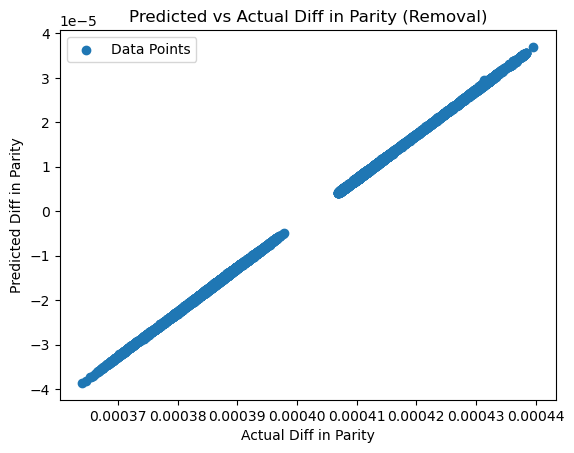

In [22]:
#fix the sacles here and I will get the graph I hopefully want
predicted_diff = decimal_array
actual_diff = difference

# Create the scatter plot
plt.scatter(actual_diff, predicted_diff, label='Data Points')

# Set the limits for both axes to be the same
#plt.xlim(0.0010, 0.0015)  # Adjust these values as needed
#plt.ylim(-0.00015, 0.00015)  # Adjust these values as needed

# Set the aspect ratio of the plot to be equal
#plt.gca().set_aspect('equal', adjustable='box')

# Set the labels for the axes
plt.xlabel('Actual Diff in Parity')
plt.ylabel('Predicted Diff in Parity')

# Set the title of the plot (optional)
plt.title('Predicted vs Actual Diff in Parity (Removal)')

# Add a legend
plt.legend()

# Show the plot
plt.show()

<h3>INF Calc on Flipped Labels and Compare them to flipping the datapoints<h3>

In [59]:
flipping_time_start = time.time()
#Flip all the labels for the encoded data and the scaled data
#The labels are the same just the training data looks different 
y_train_changed = y_train.replace({0:1,1:0})
#y_test_changed = y_test.replace({0:1,1:0})

In [60]:
#Run the Classifiers and calculate the statistical parity after changing everything
#In theory it shouldnt change anything but uhhhh lets see 
clf = eval(clf_name)(input_size=X_train.shape[-1])

num_params = len(convert_grad_to_ndarray(list(clf.parameters())))
if isinstance(clf, Logistic_Regression):
    loss_func = logistic_loss_torch
elif isinstance(clf, SVM):
    loss_func = svm_loss_torch
elif isinstance(clf, NeuralNetwork):
    loss_func = nn_loss_torch
else:
    raise NotImplementedError

In [61]:
clf = eval(clf_name)(input_size=X_train.shape[-1])

clf.fit(X_train, y_train_changed)

y_pred_test = clf.predict_proba(X_test)
y_pred_train = clf.predict_proba(X_train)

spd_1 = computeFairness(y_pred_test, X_test_orig, y_test, 0, dataset)
print("Initial statistical parity: ", spd_1)

tpr_parity_1 = computeFairness(y_pred_test, X_test_orig, y_test, 1, dataset)
print("Initial TPR parity: ", tpr_parity_1)

predictive_parity_1 = computeFairness(y_pred_test, X_test_orig, y_test, 2, dataset)
print("Initial predictive parity: ", predictive_parity_1)

accuracy_1 = computeAccuracy(y_test, y_pred_test)
print("Initial accuracy: ", accuracy_1)

Initial statistical parity:  0.06832083893440899
Initial TPR parity:  0.0622846366917561
Initial predictive parity:  -0.07730164684766444
Initial accuracy:  0.3171129025521073


In [62]:
#Original datapoints before changing the datapoints
metric_val = [spd_1, tpr_parity_0, predictive_parity_0][metric]
del_F_del_theta2 = get_del_F_del_theta(clf, X_test_orig, X_test, y_test, dataset, metric)

In [63]:
hessian_all_points2 = get_hessian_all_points(clf, X_train, y_train_changed, loss_func)

100%|██████████| 48605/48605 [03:45<00:00, 215.64it/s]


In [64]:
del_L_del_theta2 = get_del_L_del_theta(clf, X_train, y_train_changed, loss_func)

In [65]:
hinv_v2, hinv2 = get_hinv_v(hessian_all_points2, np.transpose(del_L_del_theta2))
#incorporate del_l_del_theta_i with the updated datapoint

In [66]:
inf2 = np.matmul(np.transpose(hinv_v2), del_F_del_theta2)
#For the new datapoint re-calculate the hinv_v

In [67]:
negative_hinv_v_2 = -1 * hinv_v2

In [68]:
inf2 = (-1/(len(X_train))) *inf2 

In [69]:
#First time calc
flipping_time_end = time.time() - flipping_time_start

In [33]:
#Flipping
#Make the original flips to test for the parity after each flip 
actual_df_train = train_full_df.copy()
actual_parity_list = []

for index, row in actual_df_train.iterrows():
    if row['frisked'] == 1:
        #Flip the label at income = 1 to 0
        actual_df_train.at[index,'frisked'] = 0
        actual_pred = lr_model(actual_df_train, X_test, clf)
        actual_parity = computeFairness(actual_pred, X_test_orig, y_test, 0, dataset)
        actual_parity_list.append(actual_parity)
        actual_df_train.at[index,'frisked'] = 1
        
    elif row['frisked'] == 0:
        actual_df_train.at[index,'frisked'] = 1
        actual_pred = lr_model(actual_df_train, X_test, clf)
        actual_parity = computeFairness(actual_pred, X_test_orig, y_test, 0, dataset)
        actual_parity_list.append(actual_parity)
        actual_df_train.at[index,'frisked'] = 0

In [34]:
decimal_array = [format(num, '.10f') for num in inf2]
decimal_array = [float(num) for num in decimal_array]

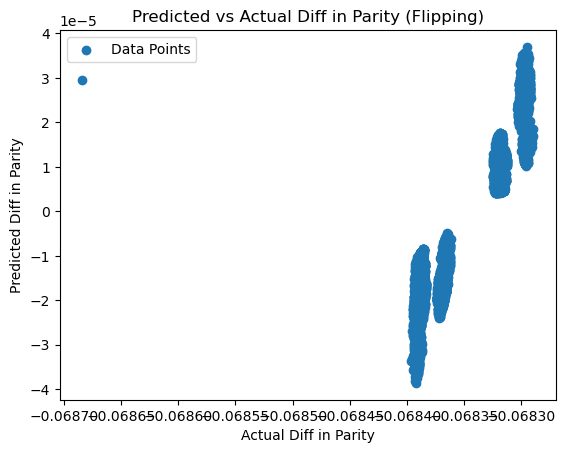

In [35]:
predicted_diff = decimal_array
actual_diff = actual_parity_list

# Create the scatter plot
plt.scatter(actual_diff, predicted_diff, label='Data Points')

# Set the labels for the axes
plt.xlabel('Actual Diff in Parity')
plt.ylabel('Predicted Diff in Parity')

# Set the title of the plot (optional)
plt.title('Predicted vs Actual Diff in Parity (Flipping)')

# Add a legend
plt.legend()

# Show the plot
plt.show()


<h4>Calculate the difference between the changed vs original<h4>

<h5>Implement Solutions<h5>
<li>Influence</li>
<li>Entropy</li>
<li>Randomized</li>


<h5>Influence Based Flips<h5>

In [70]:
if_start = time.time()
index_list = []
for i in range(len(X_train)):
    index_list.append(i)

In [71]:
#Make a copy of the training data to make flips on 
influence_train_copy = train_full_df.copy()

In [75]:
#Order the total_inf in descending order based on magnitude
combined_list = list(zip(inf2, index_list))

# Step 2: Sort the combined list based on the float values
sorted_combined_list = sorted(combined_list, key=lambda x: abs(x[0]), reverse=True)

# Step 3: Unpack the sorted list of tuples back into two separate lists
abs_sorted_float_list, abs_sorted_index_list = zip(*sorted_combined_list)
list(abs_sorted_float_list)
list(abs_sorted_index_list)
#Measure up to here for the influence functions
#This will tell us how long it takes for influence functions to determine which order I need to flip the datapoints in
#if_time: Time taken to decide the order in which the datapoints need to be flipped
#flipping_time_end = time.time() - flipping_time_start
if_end = time.time() - if_start
if_end += flipping_time_end

In [76]:
print(if_end)

298.97163367271423


In [73]:
if if_end < 0:
    if_end = -1 * if_end
else: 
    pass

In [ ]:
flip_parity_abs = []
for i in range(len(abs_sorted_index_list)):
    row_num = abs_sorted_index_list[i]
    if influence_train_copy.at[row_num,'frisked'] == 1:
        influence_train_copy.at[row_num,'frisked'] = 0
        influence_prediction = lr_model(influence_train_copy, X_test, clf)
        influence_parity = computeFairness(influence_prediction, X_test_orig, y_test, 0, dataset)
        flip_parity_abs.append(influence_parity)
        print(i)
    elif influence_train_copy.at[row_num,'frisked'] == 0:
        influence_train_copy.at[row_num,'frisked'] = 1
        influence_prediction = lr_model(influence_train_copy, X_test, clf)
        influence_parity = computeFairness(influence_prediction, X_test_orig, y_test, 0, dataset)
        flip_parity_abs.append(influence_parity)
        print(i)

In [41]:
sol_time.append(if_end)

<h5>Uncertainty Reduction/Entropy<h5>

In [42]:
entropy_start = time.time()
#Remake the dataset
entropy_train_df = train_full_df.copy()

In [43]:
#Run the LR classifier
#Use Scikit learn logistic regression rather than pre-built one
clfa = LogisticRegression(class_weight=None, max_iter=100)
log = clfa.fit(X_train,y_train)
prediction = log.predict(X_test)
#prediction_prob = log.predict_proba(X_train)
accuracy = accuracy_score(y_test,prediction)*100
print(accuracy)

68.3304790944405


In [44]:
#Obtain the predicted probabilities
predicted_prob = log.predict_proba(X_train)

In [45]:
#Log base two would be: log = math.log(x,2)
#Entropy equation would then be: -1*(p1((math.log(p1,2))+p2*(math.log(p2,2)))

#In the predicted_probabilities: first value is 0 (which is bad), second value is 1 (which is good)

#Loop through the predicted_probabilities array and calculate values
#One list will contain the index of each row in the table and the other will contain the entropy value of each row

index_list = []
entropy_list = []

for index, value in enumerate(predicted_prob):
  #Calculate p1 and p2
  p1=predicted_prob[index,0]
  p2=predicted_prob[index,1]
  #Calculate entropy in 3 steps
  entropy_calc1 = p1 * math.log(p1,2)
  entropy_calc2 = p2 * math.log(p2,2)
  entropy_final = -1 * (entropy_calc1 + entropy_calc2)

  #Append the values to their respective lists
  index_list.append(index)
  entropy_list.append(entropy_final)

In [46]:
#Rank the entropy values in decreasing order
#Match the index list with them

#Combine the two lists using zip
combined_list = list(zip(entropy_list, index_list))

#Sort the combined lust based on entropy values in descending order
sorted_list = sorted(combined_list, key = lambda x: x[0], reverse=True)

#Extract the values
sorted_ent_list, sorted_index_list = zip(*sorted_list)
entropy_end = time.time()

In [47]:
entropy_train_df['frisked'] = entropy_train_df['frisked'].astype('int')

In [48]:
ranked_ent_list = list(sorted_ent_list)
ranked_idx_list = list(sorted_index_list)

In [49]:
#After the ranking; flip based on the ranked entropy values
#Values with the highest entropy are prioritized for flipping

ranked_ent_parity_list = [spd_0]
ranked_flip = []

row_num = 0

#Loop through and flip based on the entropy values
for row in range(len(sorted_index_list)):
    row_num = ranked_idx_list[row]
    if entropy_train_df.at[row_num,'frisked'] == 0:
        entropy_train_df.at[row_num,'frisked'] = 1
        ranked_ent_pred = lr_model(entropy_train_df, X_test, clf)
        ranked_ent_parity = computeFairness(ranked_ent_pred, X_test_orig, y_test, 0, dataset)
        ranked_ent_parity_list.append(ranked_ent_parity)

    elif entropy_train_df.at[row_num,'frisked'] == 1:
        entropy_train_df.at[row_num,'frisked'] = 0
        ranked_ent_pred = lr_model(entropy_train_df, X_test, clf)
        ranked_ent_parity = computeFairness(ranked_ent_pred, X_test_orig, y_test, 0, dataset)
        ranked_ent_parity_list.append(ranked_ent_parity)

In [50]:
entropy_time = entropy_end - entropy_start
sol_time.append(entropy_time)

<h5>Randomized<h5>

In [51]:
#Training dataset
random_start = time.time()
random_training_df = train_full_df.copy()

In [52]:
#Budget of 200 random flipping
import random
random_flip_parity = []
budget = len(y_test)

for iter in range(budget):
    random_row = random.choice(random_training_df.index)
    if random_training_df.at[random_row,'frisked'] == 1:
        random_training_df.at[random_row,'frisked'] = 0
        rand_pred = lr_model(random_training_df, X_test, clf)
        rand_ranked_parity = computeFairness(rand_pred, X_test_orig, y_test, 0, dataset)
        random_flip_parity.append(rand_ranked_parity)
    elif random_training_df.at[random_row,'frisked'] == 0:
        random_training_df.at[random_row,'frisked'] = 1
        rand_pred = lr_model(random_training_df, X_test, clf)
        rand_ranked_parity = computeFairness(rand_pred, X_test_orig, y_test, 0, dataset)
        random_flip_parity.append(rand_ranked_parity)
random_end = time.time()


In [53]:
random_time = random_end - random_start
sol_time.append(random_time)

<h5>Graph Time and Parity<h5>

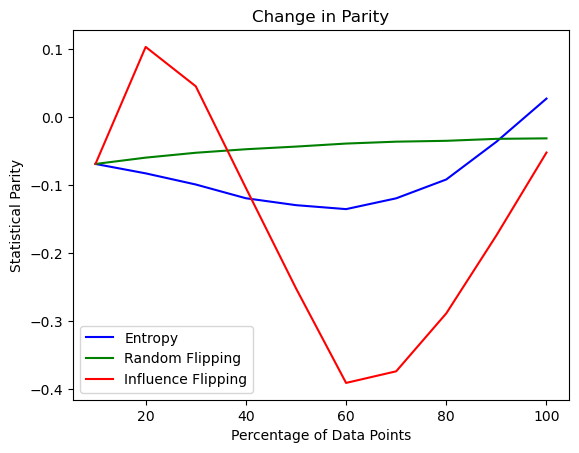

In [58]:
# Calculate the total number of data points
datapoints_entropy = len(ranked_ent_parity_list)
datapoints_random = len(random_flip_parity)
datapoints_influence = len(flip_parity_abs)

# Calculate the indices for the 5 points
indices_entropy = [int(i * datapoints_entropy / 10) for i in range(0, 10)]
indices_random = [int(i * datapoints_random / 10) for i in range(0, 10)]
indices_influence = [int(i * datapoints_influence / 10) for i in range(0, 10)]

# Extract the values at these indices
values_entropy = [ranked_ent_parity_list[index] for index in indices_entropy]
values_random = [random_flip_parity[index] for index in indices_random]
values_influence = [flip_parity_abs[index] for index in indices_influence]

# Plot the values
plt.plot([10, 20, 30, 40, 50, 60, 70, 80, 90, 100], values_entropy, label='Entropy', color='Blue')
plt.plot([10, 20, 30, 40, 50, 60, 70, 80, 90, 100], values_random, label='Random Flipping', color='Green')
plt.plot([10, 20, 30, 40, 50, 60, 70, 80, 90, 100], values_influence, label='Influence Flipping', color='Red')

# Add labels and legend
plt.xlabel('Percentage of Data Points')
plt.ylabel('Statistical Parity')
plt.title('Change in Parity')
plt.legend()

<h4>Time Comparisons<h4>

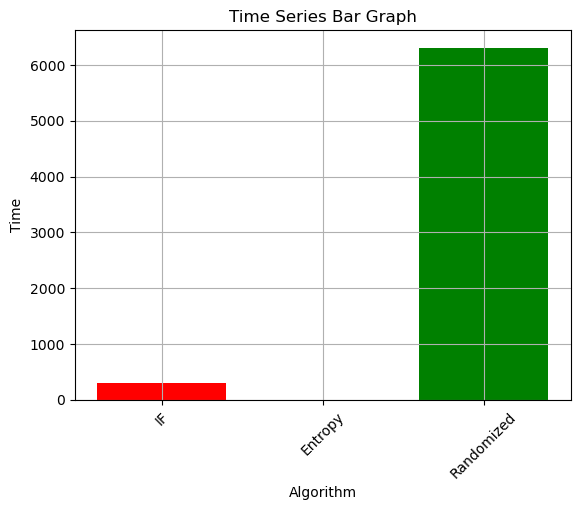

In [80]:
# Create a line chart
x_axis = ['IF', 'Entropy', 'Randomized']
# Colors for each bar
colors = ['red', 'blue', 'green']

# Create a bar graph with updated labels and colors
plt.bar(x_axis, sol_time, color=colors)
plt.title('Time Series Bar Graph')
plt.xlabel('Algorithm')
plt.ylabel('Time')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

In [79]:
print(predicted_diff)
print(actual_diff)
print(sol_time)

[2.95673e-05, 7.0198e-06, -1.44435e-05, 7.0481e-06, 7.3557e-06, 8.5209e-06, -1.63815e-05, -1.58055e-05, 1.35027e-05, -2.1253e-05, 3.48367e-05, -1.6133e-05, -1.99471e-05, -1.77951e-05, 8.9117e-06, -1.47286e-05, 8.6697e-06, 9.3519e-06, -1.90255e-05, -7.0887e-06, -1.63544e-05, 7.0198e-06, 4.7441e-06, 1.69891e-05, -2.96751e-05, -1.93142e-05, 7.8553e-06, 1.28505e-05, -1.77951e-05, -1.75158e-05, -9.492e-06, -1.79837e-05, 2.30644e-05, -2.14609e-05, -1.89146e-05, -1.60236e-05, 1.21564e-05, -1.6189e-05, 7.6812e-06, -1.51922e-05, -1.75047e-05, 1.05347e-05, 3.0167e-05, -1.49914e-05, -1.13572e-05, -1.50512e-05, 8.1979e-06, 1.01697e-05, 7.3311e-06, 2.86012e-05, 5.0035e-06, 9.2059e-06, 2.66056e-05, -1.57898e-05, -1.89146e-05, -2.49125e-05, 2.93106e-05, -1.75047e-05, 2.61338e-05, 8.4761e-06, 2.37943e-05, 2.41791e-05, 4.9448e-06, 2.51853e-05, 7.2576e-06, 7.4062e-06, -1.29343e-05, 1.40625e-05, -1.69983e-05, 1.01071e-05, -1.95787e-05, -1.8466e-05, 1.13365e-05, 7.4519e-06, -1.69065e-05, -1.35325e-05, -1.

In [78]:
sol_time[0] = if_end